In [6]:
%%writefile main.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <math.h>
#include <cuda.h>

// Define matrix size. You can override this at compile time (e.g., nvcc main.cu -DN=1024 -o main)

#ifndef MATRIX_SIZE
#define MATRIX_SIZE 512
#endif

#define TOLERANCE 1e-4

// Function to initialize a matrix with random values
void initMatrix(float *matrix, int size) {
    for (int i = 0; i < size; i++) {
        // Random values between 0 and 99
        matrix[i] = (float)(rand() % 100);
    }
}

// CPU matrix multiplication
void matrixMulCPU(float *A, float *B, float *C, int n) {
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            float sum = 0.0f;
            for (int k = 0; k < n; k++) {
                sum += A[i * n + k] * B[k * n + j];
            }
            C[i * n + j] = sum;
        }
    }
}

// GPU matrix multiplication kernel
__global__ void matrixMulGPU(const float *A, const float *B, float *C, int n) {
    // Each thread computes one element of the output matrix.
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    
    if (row < n && col < n) {
        float sum = 0.0f;
        for (int k = 0; k < n; k++) {
            sum += A[row * n + k] * B[k * n + col];
        }
        C[row * n + col] = sum;
    }
}

// Function to compare CPU and GPU results with an absolute difference tolerance.
void verifyResults(float *C_cpu, float *C_gpu, int n) {
    int errors = 0;
    for (int i = 0; i < n * n; i++) {
        float diff = fabs(C_cpu[i] - C_gpu[i]);
        if (diff > TOLERANCE) {
            errors++;
            if(errors < 10) {
                printf("Mismatch at index %d: CPU = %f, GPU = %f, diff = %f\n", i, C_cpu[i], C_gpu[i], diff);
            }
        }
    }
    if (errors > 0) {
        printf("Total mismatches: %d\n", errors);
    } else {
        printf("Results match within tolerance (%e).\n", TOLERANCE);
    }
}

int main() {
    srand(time(NULL));

    int matrixSize = MATRIX_SIZE;
    size_t bytes = matrixSize * matrixSize * sizeof(float);

    // Allocate host memory
    float *h_A      = (float *)malloc(bytes);
    float *h_B      = (float *)malloc(bytes);
    float *h_C_CPU  = (float *)malloc(bytes);
    float *h_C_GPU  = (float *)malloc(bytes);

    // Initialize matrices
    initMatrix(h_A, matrixSize * matrixSize);
    initMatrix(h_B, matrixSize * matrixSize);

    // ---------------------------
    // CPU matrix multiplication
    // ---------------------------
    cudaEvent_t startCPU, endCPU;
    cudaEventCreate(&startCPU);
    cudaEventCreate(&endCPU);

    cudaEventRecord(startCPU, 0);
    matrixMulCPU(h_A, h_B, h_C_CPU, matrixSize);
    cudaEventRecord(endCPU, 0);
    cudaEventSynchronize(endCPU);

    float cpu_time;
    cudaEventElapsedTime(&cpu_time, startCPU, endCPU);
    printf("CPU Execution Time: %f ms\n", cpu_time);

    // ---------------------------
    // GPU matrix multiplication
    // ---------------------------
    // Allocate device memory
    float *d_A, *d_B, *d_C;
    cudaMalloc((void**)&d_A, bytes);
    cudaMalloc((void**)&d_B, bytes);
    cudaMalloc((void**)&d_C, bytes);

    // Copy data to GPU
    cudaMemcpy(d_A, h_A, bytes, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, bytes, cudaMemcpyHostToDevice);

    // Define grid and block dimensions.
    // Here we use 16x16 threads per block.
    int TILE_SIZE = 16;
    dim3 blockDim(TILE_SIZE, TILE_SIZE);
    dim3 gridDim((matrixSize + blockDim.x - 1) / blockDim.x,
                 (matrixSize + blockDim.y - 1) / blockDim.y);

    // Create CUDA events for GPU timing (kernel execution time).
    cudaEvent_t startGPU, endGPU;
    cudaEventCreate(&startGPU);
    cudaEventCreate(&endGPU);

    cudaEventRecord(startGPU, 0);
    matrixMulGPU<<<gridDim, blockDim>>>(d_A, d_B, d_C, matrixSize);
    cudaEventRecord(endGPU, 0);
    cudaEventSynchronize(endGPU);

    float gpu_kernel_time;
    cudaEventElapsedTime(&gpu_kernel_time, startGPU, endGPU);
    printf("GPU Kernel Execution Time: %f ms\n", gpu_kernel_time);

    // Copy results back to host
    cudaMemcpy(h_C_GPU, d_C, bytes, cudaMemcpyDeviceToHost);

    // Verify results between CPU and GPU
    verifyResults(h_C_CPU, h_C_GPU, matrixSize);

    // Compute speedup factor (CPU time / GPU kernel time)
    float speedup = cpu_time / gpu_kernel_time;
    printf("Speedup (CPU time / GPU kernel time): %f\n", speedup);

    // Cleanup host and device memory, and destroy CUDA events
    free(h_A);
    free(h_B);
    free(h_C_CPU);
    free(h_C_GPU);
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    cudaEventDestroy(startCPU);
    cudaEventDestroy(endCPU);
    cudaEventDestroy(startGPU);
    cudaEventDestroy(endGPU);

    return 0;
}


Overwriting main.cu


In [14]:
!nvcc -arch=native -o main main.cu -DMATRIX_SIZE=2048

In [9]:
!./main

CPU Execution Time: 53.650082 ms
GPU Kernel Execution Time: 0.192512 ms
Results match within tolerance (1.000000e-04).
Speedup (CPU time / GPU kernel time): 278.684357


In [11]:
!./main

CPU Execution Time: 729.264404 ms
GPU Kernel Execution Time: 0.608448 ms
Results match within tolerance (1.000000e-04).
Speedup (CPU time / GPU kernel time): 1198.564819


In [13]:
!./main

CPU Execution Time: 7545.719238 ms
GPU Kernel Execution Time: 4.606720 ms
Results match within tolerance (1.000000e-04).
Speedup (CPU time / GPU kernel time): 1637.980835


In [16]:
!./main

CPU Execution Time: 88817.101562 ms
GPU Kernel Execution Time: 47.928032 ms
Results match within tolerance (1.000000e-04).
Speedup (CPU time / GPU kernel time): 1853.134766


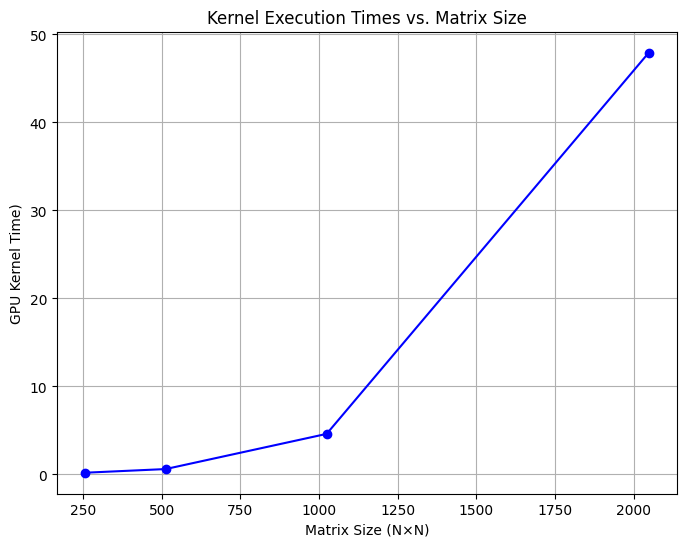

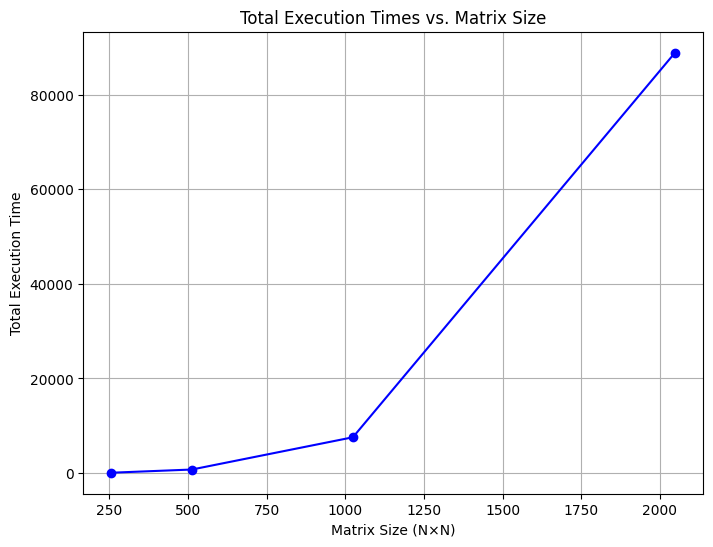

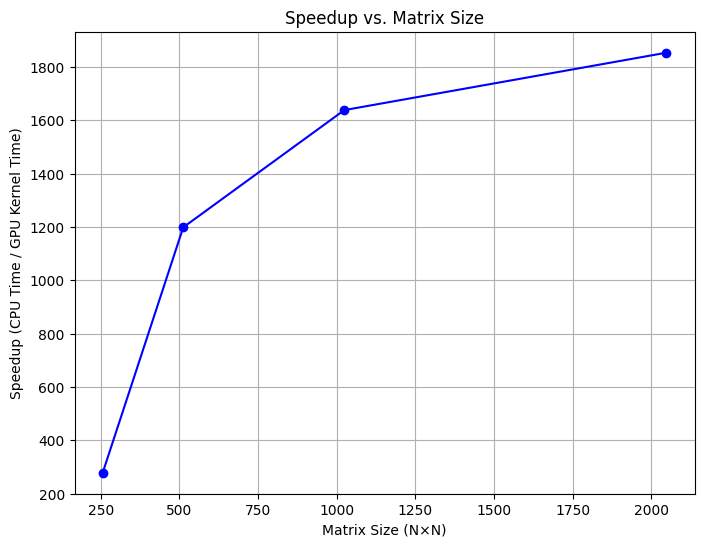

In [3]:
import matplotlib.pyplot as plt

matrix_sizes = [256, 512, 1024, 2048]
cpu_times = [53.650082, 729.264404, 7545.719238, 88817.101562] # in ms (cpu times)
gpu_times = [0.192512, 0.608448, 4.606720, 47.928032] # in ms (kernel times)
total_execution_times = [cpu + gpu for cpu, gpu in zip(cpu_times, gpu_times)]
speedup = [cpu / gpu for cpu, gpu in zip(cpu_times, gpu_times)]

plt.figure(figsize=(8,6))
plt.plot(matrix_sizes, gpu_times, marker='o', linestyle='-', color='b')
plt.xlabel("Matrix Size (N×N)")
plt.ylabel("GPU Kernel Time)")
plt.title("Kernel Execution Times vs. Matrix Size")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(matrix_sizes, total_execution_times, marker='o', linestyle='-', color='b')
plt.xlabel("Matrix Size (N×N)")
plt.ylabel("Total Execution Time")
plt.title("Total Execution Times vs. Matrix Size")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(matrix_sizes, speedup, marker='o', linestyle='-', color='b')
plt.xlabel("Matrix Size (N×N)")
plt.ylabel("Speedup (CPU Time / GPU Kernel Time)")
plt.title("Speedup vs. Matrix Size")
plt.grid(True)
plt.show()


In [19]:
cpu_times = [53.650082, 729.264404, 7545.719238, 88817.101562]         # in ms (example values)
gpu_times = [0.192512, 0.608448, 4.606720, 47.928032]  
total_execution_times = cpu_times + gpu_times
print(total_execution_times)

[53.650082, 729.264404, 7545.719238, 88817.101562, 0.192512, 0.608448, 4.60672, 47.928032]
